In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install pingouin


Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
import sklearn
print(sklearn.__version__)

1.5.2


In [ ]:
# import neccessary packages
import pandas as pd
import numpy as np
import os
import re
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install shap
import shap
import scipy.stats as stats
!pip install missingno
import missingno as msno
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import mannwhitneyu
import pingouin as pg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory
os.chdir("/content/drive/MyDrive/FAINT")
print(os.getcwd())

/content/drive/MyDrive/FAINT


In [ ]:
# define data path and upload master dataset
file_path ='datain/preprocessed_faint.csv'
df_orig = pd.read_csv(file_path)

In [ ]:
# drop donors that we are not able to get recordings and VVR scores == donor_id=56
df_filtered= df_orig.loc[~df_orig['donor_id'].isin([56])].copy()

In [ ]:
# recode categorical variables --> convert them to string
categoric = ['Condition', 'Gender']
df_filtered[categoric]=df_filtered[categoric].astype(str)
print(df_filtered[categoric].dtypes)

Condition    object
Gender       object
dtype: object


In [ ]:
# recode donor type and gender
df_filtered['Condition'] = df_filtered['Condition'].replace({'1.0': 'control', '2.0': 'sensitive', '3.0':'new'})
df_filtered['Gender'] = df_filtered['Gender'].replace({'1.0': 'male', '2.0': 'female'})

<Axes: >

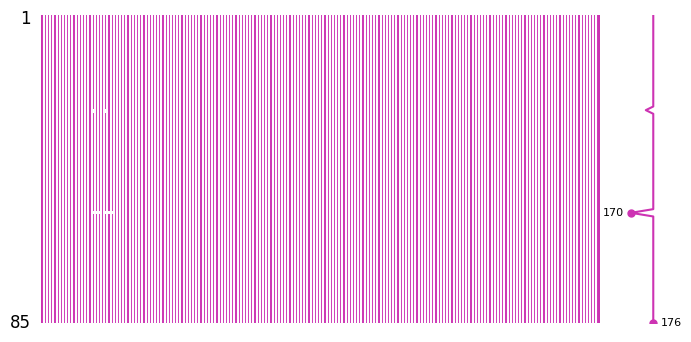

In [ ]:
 #  check missingness pattern across groups - control group
msno.matrix(df_filtered.loc[df_filtered['Condition']=='control'],  figsize=(8, 4),  fontsize=10, color=(0.802, 0.2, 0.702))

<Axes: >

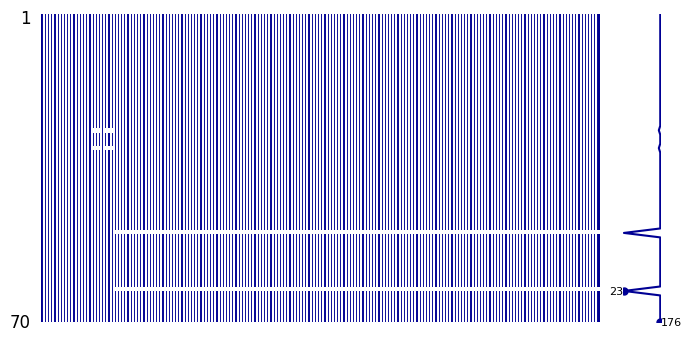

In [ ]:
 # check missingness pattern across groups - sensitive group
msno.matrix(df_filtered.loc[df_filtered['Condition']=='sensitive'],  figsize=(8, 4),  fontsize=10, color=(0.0, 0.0, 0.58))

<Axes: >

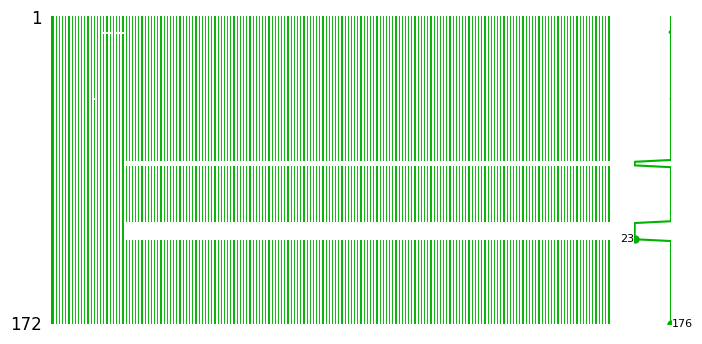

In [ ]:
# check missingness pattern across groups - new donors
msno.matrix(df_filtered.loc[df_filtered['Condition']=='new'],  figsize=(8, 4),  fontsize=10, color=(0.0, 0.7, 0.0))

In [ ]:
# define subsets for features
vvr_col =['VVR_phys_tp_4', 'VVR_phys_tp_5', 'VVR_phys_tp_6', 'VVR_phys_tp_7', 'VVR_psych_tp_4','VVR_psych_tp_5', 'VVR_psych_tp_6', 'VVR_psych_tp_7']
ssas_col=['Q4.1_1', 'Q4.1_2', 'Q4.1_3', 'Q4.1_4', 'Q4.1_5', 'Q4.1_6','Q4.1_7', 'Q4.1_8', 'Q4.1_9', 'Q4.1_10']
au_col= df_orig.filter(regex='au').columns.to_list()
feature_col= au_col+ssas_col

In [ ]:
# create a function to apply tukey test
def group_anova_tukey (data, value):
  f, p = stats.f_oneway(data[data['Condition']=="control"][value],
                        data[data['Condition']=="sensitive"][value],
                        data[data['Condition']=="new"][value])
  if p<=0.05:
      tukey_test=pairwise_tukeyhsd(data[value], data['Condition'], alpha=0.05)
      print(f"Anova results for {value} across donor groups:")
      print(f"F_stat: {round(f,2)}, p-value: {round(p,2)}")
      print("\n")
      print(tukey_test)
  else:
      print(f"Anova results for {value} across donor groups:")
      print(f"F_stat: {round(f,2)}, p-value: {round(p,2)}")
      print("No significant difference across groups")

In [ ]:
# create flag variable to group missing cases
df_filtered['missing_vvr'] = df_filtered[vvr_col].isna().any(axis=1).astype(int)
df_filtered['missing_other'] = df_filtered[feature_col].isna().any(axis=1).astype(int)

In [ ]:
# define total VVR score  (will be used exploratory purpose)
df_filtered['VVR_sum_initial']=df_filtered[vvr_col].sum(axis=1)

In [ ]:
# apply mann whitney u test on VVR distributions by missingness flag
m1 = df_filtered[df_filtered['missing_other']==0]['VVR_sum_initial'].values
m2 = df_filtered[df_filtered['missing_other']==1]['VVR_sum_initial'].values

u, p =mannwhitneyu(m1, m2)
print('U-stat:', u)
print('p_value:', p)
if p<0.05:
  print("Distributions are significantly different")
else:
  print ("Not different")


U-stat: 2176.5
p_value: 0.39725631112587334
Not different


In [ ]:
# apply listwise deletion
df_final =df_filtered.loc[(~df_orig['donor_id'].isin([56])) & (df_filtered['missing_vvr']==0) & (df_filtered['missing_other']==0)].copy()

In [ ]:
# create a dataframe including only VVR sub-items
df_vvr=df_final[vvr_col].copy()
df_vvr.head()

,VVR_phys_tp_4,VVR_phys_tp_5,VVR_phys_tp_6,VVR_phys_tp_7,VVR_psych_tp_4,VVR_psych_tp_5,VVR_psych_tp_6,VVR_psych_tp_7
0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0
1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,5.0,5.0,20.0,7.0,6.0,9.0,20.0,5.0
3,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [ ]:
# apply cronbach`s alpha test to check internal validitiy
alpha, CI = pg.cronbach_alpha(data=df_vvr)
print(f"Cronbach`s alpha for VVR: {alpha: .3f}")
print(f"Confidence intervals of the test: {CI:}")

Cronbach`s alpha for VVR:  0.782
Confidence intervals of the test: [0.743 0.817]


In [ ]:
# create total VVR and SSAS scores
df_final['VVR_sum']=df_final[vvr_col].sum(axis=1)
df_final['SSAS_sum']=df_final[ssas_col].sum(axis=1)

# find mean value of vvr score --> use as threshold to identify vvr risk groups
mean_threshold = df_final['VVR_sum'].mean()

# define VVR group
df_final['VVR_group']= np.where(df_final['VVR_sum']>mean_threshold, 1, 0)


In [ ]:
# cross check --> no missing values
print("number of null values in dataset:",df_final.isna().sum().sum())

number of null values in dataset: 0


In [ ]:
print("number of obeservation in dataset:",df_final.shape[0])

number of obeservation in dataset: 306


In [ ]:
print("number of obeservation by donor type:")
df_final['Condition'].value_counts()

number of obeservation by donor type:


,count
Condition,
new,157
control,83
sensitive,66


In [ ]:
print("number of obeservation by gender:")
df_final['Gender'].value_counts()

number of obeservation by gender:


,count
Gender,
female,179
male,127


In [ ]:
# apply anova-tukey on total VVR score by donor type
group_anova_tukey(df_final, "VVR_sum")

Anova results for VVR_sum across donor groups:
F_stat: 14.59, p-value: 0.0


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
control       new   3.4149 0.0124 0.6073  6.2224   True
control sensitive   7.8237    0.0 4.4118 11.2355   True
    new sensitive   4.4088  0.002 1.3739  7.4437   True
-------------------------------------------------------


In [ ]:
# apply anova-tukey on total SSAS score by donor type
group_anova_tukey(df_final, "SSAS_sum")

Anova results for SSAS_sum across donor groups:
F_stat: 1.06, p-value: 0.35
No significant difference across groups


In [ ]:
# apply anova-tukey on age by donor type
group_anova_tukey(df_final, "Age")

Anova results for Age across donor groups:
F_stat: 1.34, p-value: 0.26
No significant difference across groups


In [ ]:
# apply anova-tukey on BMI by donor type
group_anova_tukey(df_final, "BMI")

Anova results for BMI across donor groups:
F_stat: 0.04, p-value: 0.96
No significant difference across groups


In [ ]:
# apply chi2 test the association between gender and donor type
chi, p, _, _=stats.chi2_contingency(pd.crosstab(df_final['Gender'], df_final['Condition']))
print('chi_square:', chi)
print('p_value:', p)
if p<0.05:
  print("reject the null-> indepent")
else:
  print("independent")

chi_square: 7.026144256555642
p_value: 0.029805208219423777
reject the null-> indepent


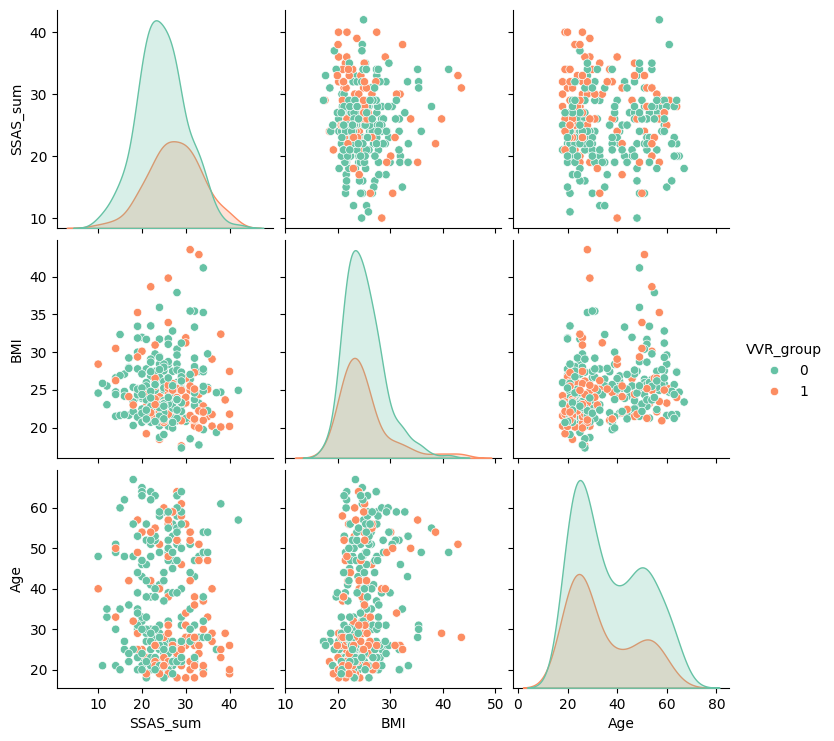

In [ ]:
# create a paiplot by VVR group
sns.pairplot(df_final.loc[:,  ['SSAS_sum','BMI', 'Condition','Age','VVR_group']], hue="VVR_group", palette='Set2')

In [ ]:
# create a column to report categorical-name of VVR group
df_final['VVR_group_name']=df_final['VVR_group'].map({0: 'Low VVR', 1: 'High VVR'})

Text(0.5, 0, 'VVR group')

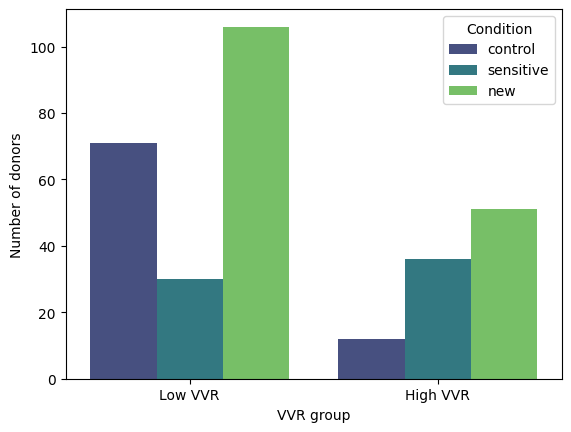

In [ ]:
# check distribution of VVR group across donor type
palette = {"control": "#3e4a89", "sensitive": "#26828e", "new":"#6ece58" }

sns.countplot(
    data=df_final,
    x='VVR_group_name',
    hue='Condition',
    linewidth=.7,
    palette=palette,
)

plt.ylabel("Number of donors")
plt.xlabel("VVR group")


<ipython-input-35-c9b690838d18>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


Text(0.5, 0, 'VVR group')

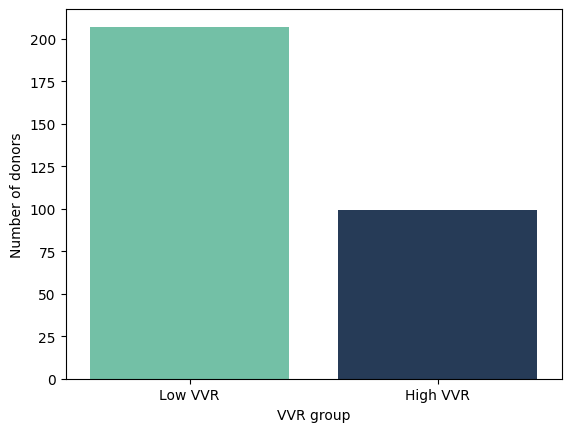

In [ ]:
# check distribution of VVR group
palette = {"Low VVR": "#66CDAA", "High VVR": "#1E3A5F" }

sns.countplot(
    data=df_final,
    x='VVR_group_name',
    linewidth=.7,
    palette=palette,
)

plt.ylabel("Number of donors")
plt.xlabel("VVR group")


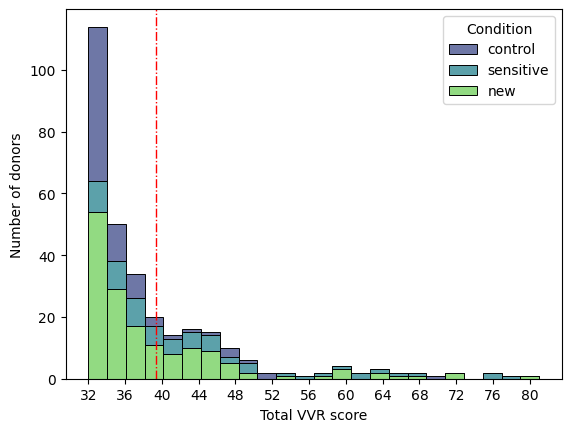

In [ ]:
# check distribution of total VVR score by donor type
palette = {"control": "#3e4a89", "sensitive": "#26828e", "new":"#6ece58" }

sns.histplot(
    data=df_final,
    x='VVR_sum',
    hue='Condition',
    binwidth=2,
    multiple="stack",
    linewidth=.7,
    palette=palette,
)


plt.xticks(ticks=range(32,82,4))
plt.ylabel("Number of donors")
plt.xlabel("Total VVR score")
plt.axvline(x=mean_threshold,
            color='red',
            linestyle='-.',
            linewidth=1)



plt.show()

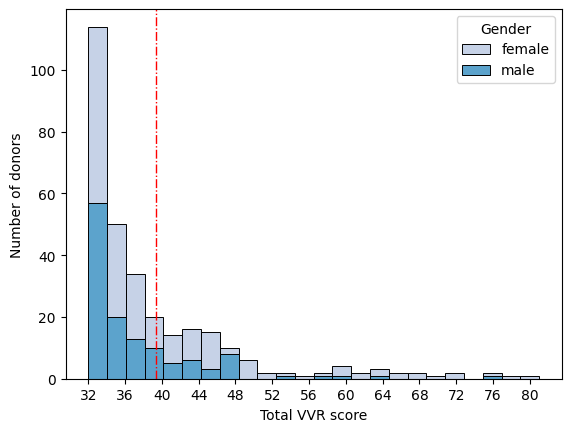

In [ ]:
# check distribution of  total VVR scores by gender
sns.histplot(
    data=df_final,
    x='VVR_sum',
    hue='Gender',
    binwidth=2,
    multiple="stack",
    linewidth=.7,
   palette='PuBu'
)


plt.xticks(ticks=range(32,82,4))
plt.ylabel("Number of donors")
plt.xlabel("Total VVR score")
plt.axvline(x=mean_threshold,
            color='red',
            linestyle='-.',
            linewidth=1)


plt.show()

<ipython-input-38-336ac503be0b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


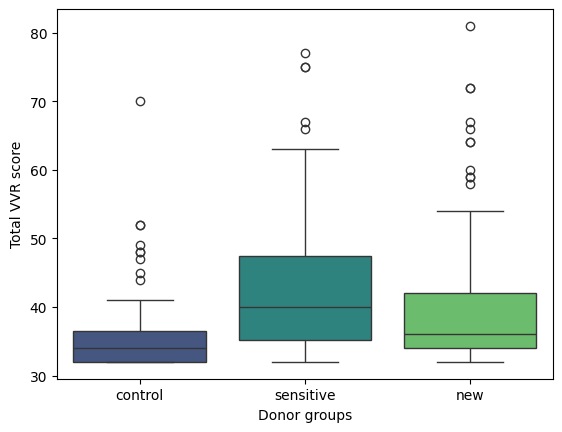

In [ ]:
# produce box plots representation of total VVR score by donor type
sns.boxplot(
    data=df_final,
    y='VVR_sum',
    x='Condition',
    palette='viridis'
)

plt.ylabel("Total VVR score")
plt.xlabel("Donor groups")
plt.show()

<ipython-input-39-f83986aaa414>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


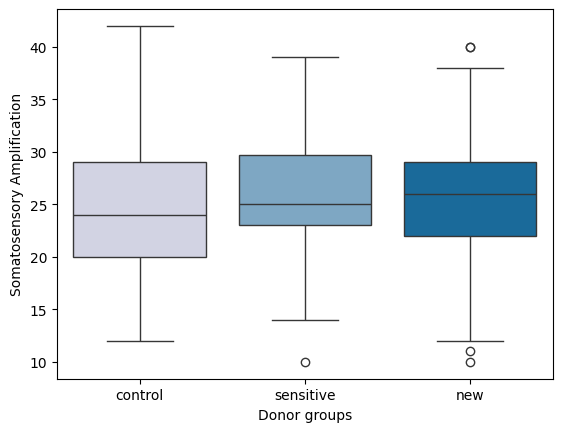

In [ ]:
# produce box plots representation of total SSAS score by donor type
sns.boxplot(
    data=df_final,
    y='SSAS_sum',
    x='Condition',
    palette='PuBu'
)

plt.ylabel("Somatosensory Amplification")
plt.xlabel("Donor groups")
plt.show()

<ipython-input-40-a032331951ee>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


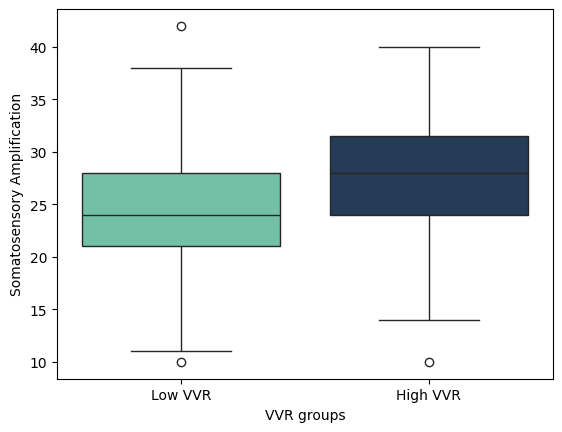

In [ ]:
# produce box plots representation of total SSAS score by VVR group
palette = {"Low VVR": "#66CDAA", "High VVR": "#1E3A5F" }

sns.boxplot(
    data=df_final,
    y='SSAS_sum',
    x='VVR_group_name',
    palette=palette
)

plt.ylabel("Somatosensory Amplification")
plt.xlabel("VVR groups")
plt.show()

In [ ]:
# apply mann whitney u test by vvr group
s1 = df_final[df_final['VVR_group']==0]['SSAS_sum'].values
s2 = df_final[df_final['VVR_group']==1]['SSAS_sum'].values

u, p =mannwhitneyu(s1, s2)

print ("Is the difference in mean SSAS score significantly different across VVR group")
print('U-stat:', u)
print('p_value:', p)
if p<0.05:
  print("Distributions are significantly different")
else:
  print ("Not different")

Is the difference in mean SSAS score significantly different across VVR group
U-stat: 7231.0
p_value: 3.044095636992266e-05
Distributions are significantly different


In [ ]:
# create a list to flag neccessary columns
neccessary_col=df_final.filter(regex='au').columns.to_list()
neccessary_col.extend(['donor_id',
                       'VVR_sum',
                       'SSAS_sum',
                       'Condition',
                       'Gender',
                       'VVR_group'
  ])

# drop unnecessary columns
df= df_final[neccessary_col].copy()

In [ ]:
# define an output path to extract cleaned dataset
output_path ='datain/cleaned_faint.csv'
df.to_csv(output_path, index=False)